# Gaussian Process in 1D (GP lab part 1)

**Machine Learning, University of Zaragoza, Ruben Martinez-Cantin**

This document shows how to use Gaussian processes for regression, and how important are the kernel function and hyperparameters.

You can use this code to play with different configurations using a popular GP library (GPy).

(based on GPSS labs)

# How to submit the results

Make a copy of this file in your Drive. Then you can use textboxes to write directly your report. Download as .ipynb and submit that file in Moodle.

In this part of the lab, we are going to use the [GPy library](http://sheffieldml.github.io/GPy/), which is not installed by default in colab, but we can get it from pip.

In [ ]:
#!pip install GPy

In [2]:
#@title import libraries
import numpy as np
import scipy as sp
import GPy

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 6)
rcParams['legend.fontsize'] = 16
rcParams['axes.labelsize'] = 16

We will use the [weight dataset](https://drive.google.com/file/d/1YYyQG-xuS1OV5Ww1ytZLzhe3YdvE_NKG/view?usp=sharing) from [Philipp Hennig](https://uni-tuebingen.de/en/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/methoden-des-maschinellen-lernens/personen/philipp-hennig/)

In [ ]:
!wget https://raw.githubusercontent.com/rmcantin/gp_lab/main/datasets/weightdata_clean.mat

Size inputs: (43, 1) Size outputs (43, 1)


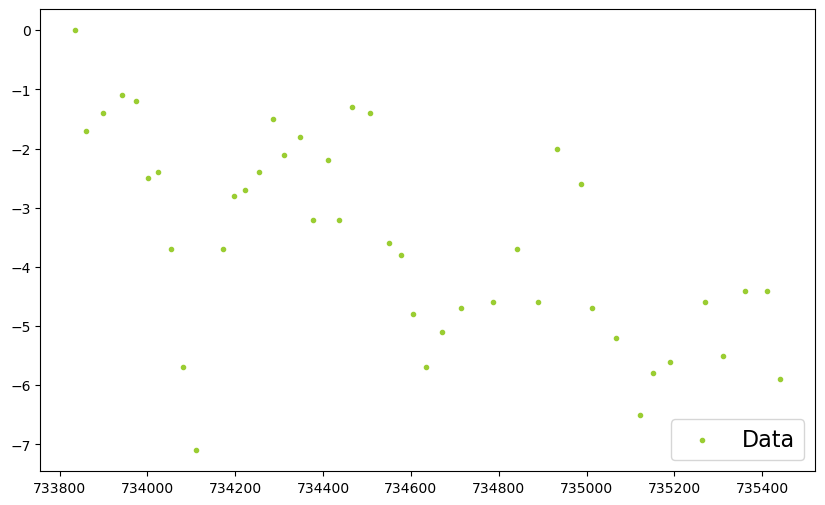

In [86]:
#@title Load data
# You can also use the weight dataset by uncommenting these lines
data=sp.io.loadmat('weightdata_clean.mat')
X = np.atleast_2d(data['dat'][:,0]).T
Y = np.atleast_2d(data['dat'][:,1]).T

# This can be use to subsample the dataset
subsample = 20
X = X[::subsample,:]
Y = Y[::subsample,:]

# Make sure the data is there
print("Size inputs:", X.shape, "Size outputs",Y.shape)
plt.scatter(X, Y, color='yellowgreen', marker='.',label='Data')
plt.legend(loc='lower right')

Here we define a quick plotting utility function for our GP fits. There are a number of plotting options available in GPy, but we will use the below method, which plots the mean and 95% confidence fit of a GP for a given input $\mathbf{X}^*$. Optionally, we will allow it to plot the initial training points.

In [74]:
# We are going to use this function later to plot the Gaussian process
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5,
                     label=r"95% confidence interval")
    # Plot GP mean and initial training points
    plt.plot(X, m, "-", label="Mean prediction")

    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2, label="sample points")

    plt.legend()

    plt.xlabel("x"), plt.ylabel("f(x)")

# Using GPy



## Covariance functions, aka kernels

We will define a covariance function, from hereon referred to as a kernel, using `GPy`. The most commonly used kernel in machine learning is the Gaussian-form radial basis function (RBF) kernel. It is also commonly referred to as the exponentiated quadratic or squared exponential kernel &ndash; all are equivalent.

The definition of the (1-dimensional) RBF kernel has a Gaussian-form, defined as:

$$
    \kappa_\mathrm{rbf}(x,x') = \sigma^2\exp\left(-\frac{(x-x')^2}{2\mathscr{l}^2}\right)
$$

It has two parameters, described as the variance, $\sigma^2$ and the lengthscale $\mathscr{l}$.

In GPy, we define our kernels using the input dimension as the first argument, in the simplest case `input_dim=1` for 1-dimensional regression. We can also explicitly define the parameters, but for now we will use the default values:

In [75]:
# Create a 1-D RBF kernel with default parameters
# If you type GPy.kern. and wait, autocomplete will show you all available kernels
k = GPy.kern.RBF(input_dim=1)

# Preview the kernel's parameters
display(k)

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


## Types of covariance function

There are many different covariance functions already implemented in `GPy`. Aside from the `RBF` kernel, there are others such as the following:
- `Exponential`
- `Matern32`
- `Matern52`
- `Brownian`
- `Bias`
- `Linear`
- `StdPeriodic`
- `Cosine`
- `PeriodicMatern32`,

Note: when defining these, all are preceded by `GPy.kern.` The following are some examples of the [Matérn 5/2](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function) and Cosine kernels, compared with the RBF kernel:

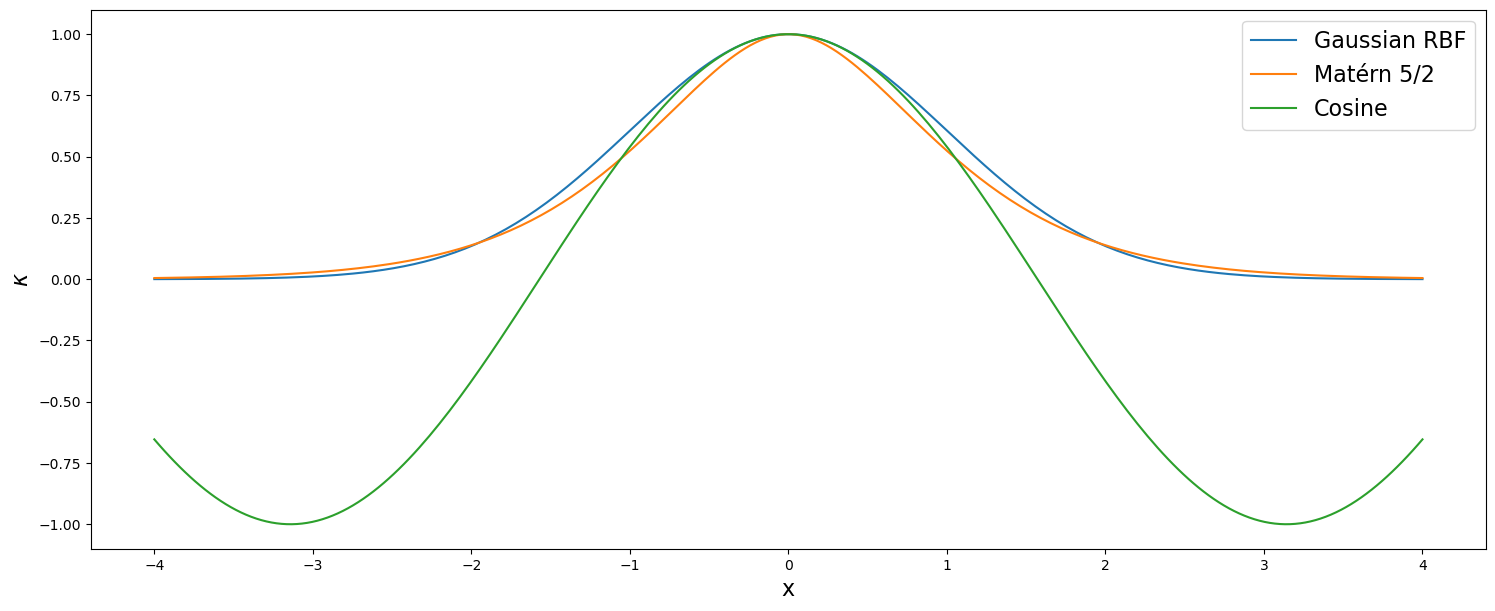

In [76]:
# Our sample space : 100 samples in the interval [-4,4]
Xp = np.linspace(-4.,4.,250)[:, None]

# RBF kernel
k_R = GPy.kern.RBF(1)
C_R = k_R.K(Xp, np.array([[0.]]))

# Matern 5/2
k_M = GPy.kern.Matern52(1)
C_M = k_M.K(Xp, np.array([[0.]]))

# Cosine
k_C = GPy.kern.Cosine(1)
C_C = k_C.K(Xp, np.array([[0.]]))

plt.figure(figsize=(18,7))
plt.plot(Xp, C_R, Xp, C_M, Xp, C_C);
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.legend(labels=["Gaussian RBF", "Matérn 5/2", "Cosine"]);

## Combining kernels
We can easily combine kernels using GPy using the + and * operators, respectively denoting addition and product of kernels.

In [77]:
# Create the first kernel: a 1-D RBF with lengthscale 2.0
k_R = GPy.kern.RBF(1, lengthscale=2., name="RBF")
# Create the second kernel: a 1-D Matern52 with variance 2.0 and lengthscale 4.0
k_M = GPy.kern.Matern52(1, variance=2., lengthscale=4., name="Matern52")

# Add the kernels together
k_sum = k_R + k_M
# Preview the properties of the composite kernel
k_sum

sum.,value,constraints,priors
RBF.variance,1.0,+ve,
RBF.lengthscale,2.0,+ve,
Matern52.variance,2.0,+ve,
Matern52.lengthscale,4.0,+ve,


## Sampling from a Gaussian Process

We can also sample from the kernel prior by creating a covariance matrix over a sample space and sampling from a zero-mean multivariate normal distribution with covariance $\mathbf{K}$ using the following function. You can use the previous kernels (including composite kernels) and generate samples of functions to see the behaviour of each kernel.

In [78]:
def plot_K_samples(kernel, N=2):
    Xp = np.linspace(0, 5., 250)[:, None]
    # Zero mean
    mu = np.zeros((250))
    # Get the covariance matrix
    C = kernel.K(Xp)

    # Sample 5 times from a multivariate Gaussian distribution with mean 0 and covariance k(X,X)
    Z  = np.random.multivariate_normal(mu, C, N)

    for j in range(N): # Loop through samples
        plt.plot(Xp[:],Z[j,:])

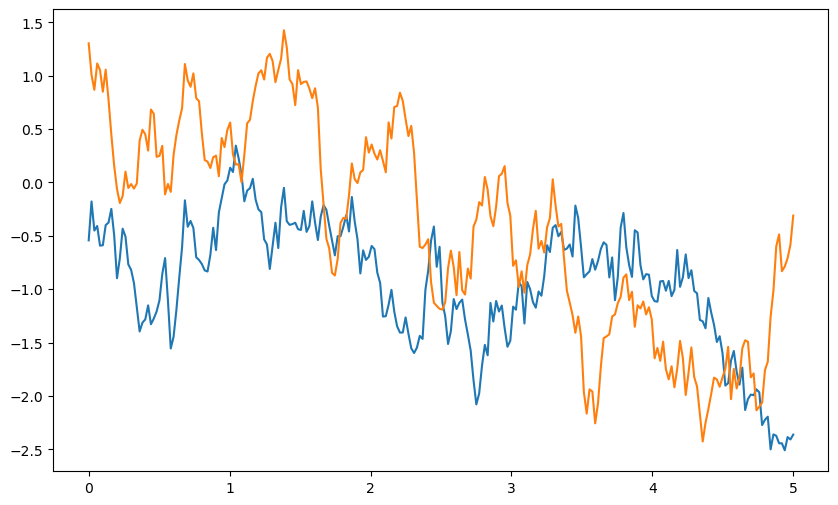

In [93]:
k = GPy.kern.Exponential(1)
plot_K_samples(k)

## Gaussian process regression
In future exercises, we are going to implement our own Gaussian process. For the time being we can do Gaussian process regression using `GPy`, by creating a GP regression model with sample points $(\mathbf{X}, \mathbf{Y})$ and the Gaussian RBF kernel:

In [100]:
k = GPy.kern.RBF(input_dim = 1)

m = GPy.models.GPRegression(X, Y, k)
m_sum = GPy.models.GPRegression(X, Y, k_sum)
m_C = GPy.models.GPRegression(X, Y, k_C)



# Preview the model's configuration
display(m)
display(m_sum)
display(m_C)


GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


GP_regression.,value,constraints,priors
sum.RBF.variance,0.24145434144382516,+ve,
sum.RBF.lengthscale,2.0,+ve,
sum.Matern52.variance,12.858851072290129,+ve,
sum.Matern52.lengthscale,173.3865678114231,+ve,
Gaussian_noise.variance,1.0,+ve,


GP_regression.,value,constraints,priors
Cosine.variance,0.9967670264918705,+ve,
Cosine.lengthscale,0.01602399002736881,+ve,
Gaussian_noise.variance,1.0,+ve,


We can use the prediction tools from GPy to obtain our model.

Note that, becuase there is no parametric model to plot, we estimate the prediction (predictive mean and variance) at a large set of points spread along the input space $X_{new}$ and that is what we plot.

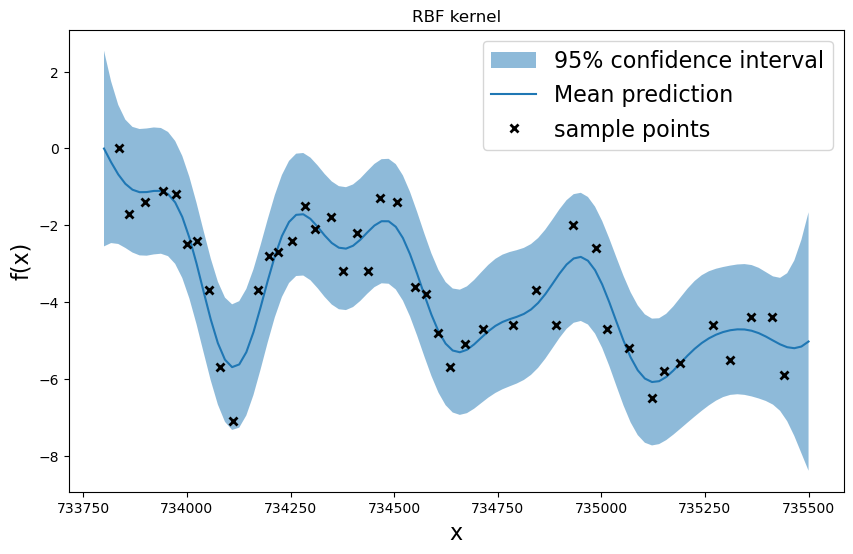

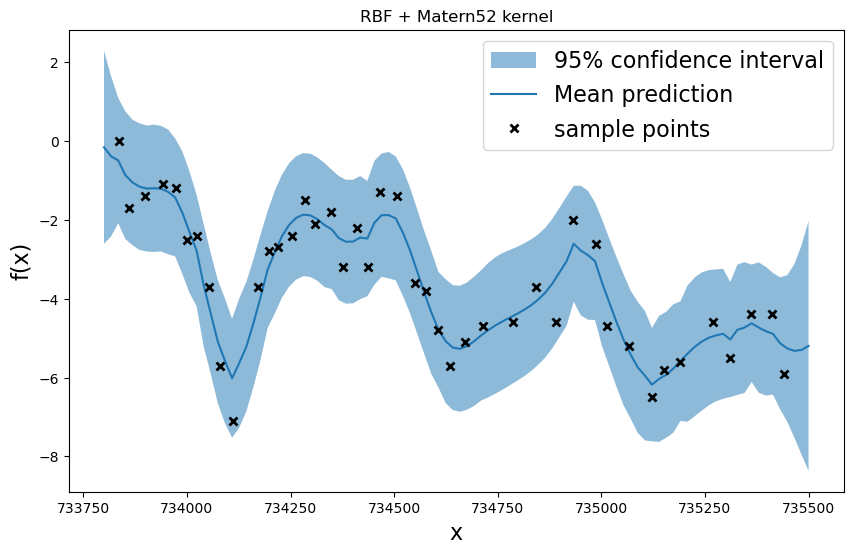

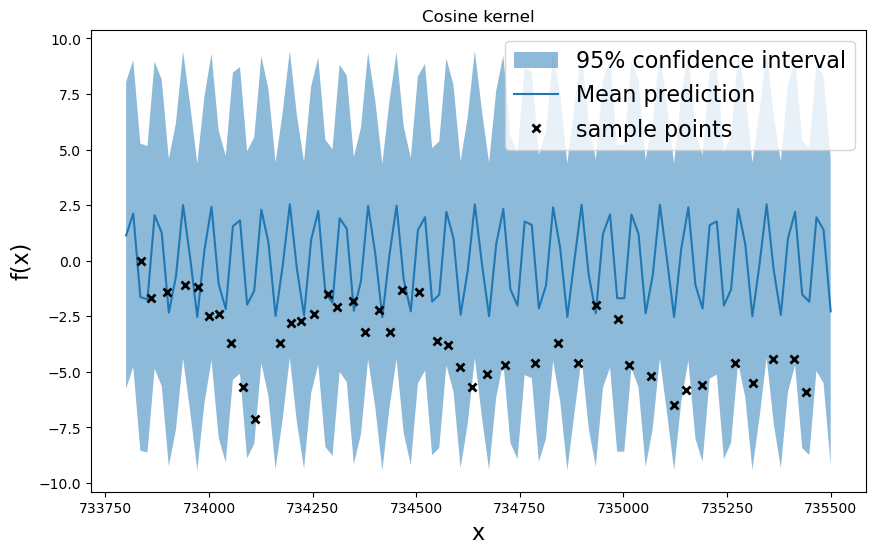

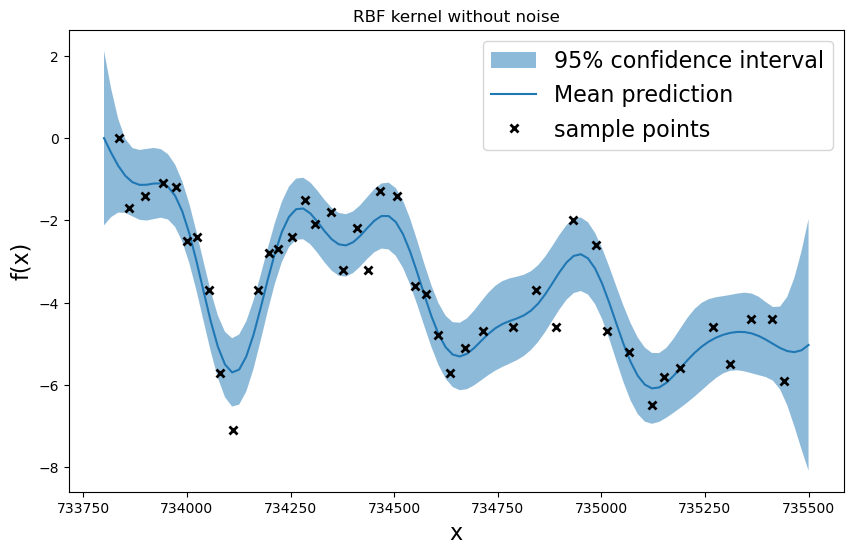

In [126]:
# New test points to sample function from
Xnew = np.linspace(733800, 735500, 100)[:, None]

# Use GPy model to calculate the mean and covariance of the fit at Xnew
mean, Cov = m.predict(Xnew, full_cov=True)

mean_sum , Cov_sum = m_sum.predict(Xnew, full_cov=True)
mean_C, Cov_C = m_C.predict(Xnew, full_cov=True)


# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("RBF kernel")
plt.show()

plot_gp(Xnew, mean_sum, Cov_sum, training_points=(X,Y))
plt.title("RBF + Matern52 kernel")
plt.show()

plot_gp(Xnew, mean_C, Cov_C, training_points=(X,Y))
plt.title("Cosine kernel")
plt.show()

plot_gp(Xnew, mean_m_noiseless, Cov_noiseless, training_points=(X,Y))
plt.title("RBF kernel without noise")
plt.show()



We can see that the uncertainty can be very large because it combines both the model uncertainty and the observation uncertainty. If we use instead:

```
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
```
we can obtain the prediction without the observation noise. We can see that the uncertainty is much smaller, because that would be only the uncertainty due to the model and not the data.

We can change the values of the hyperparameters by hand and see the performance of the regression model with different hyperparameters.

Here, we also use a built-in function for plotting in GPy. In this case, you can also replace `m.plot()` with `m.plot_noiseless()` if you want to ignore the data noise.

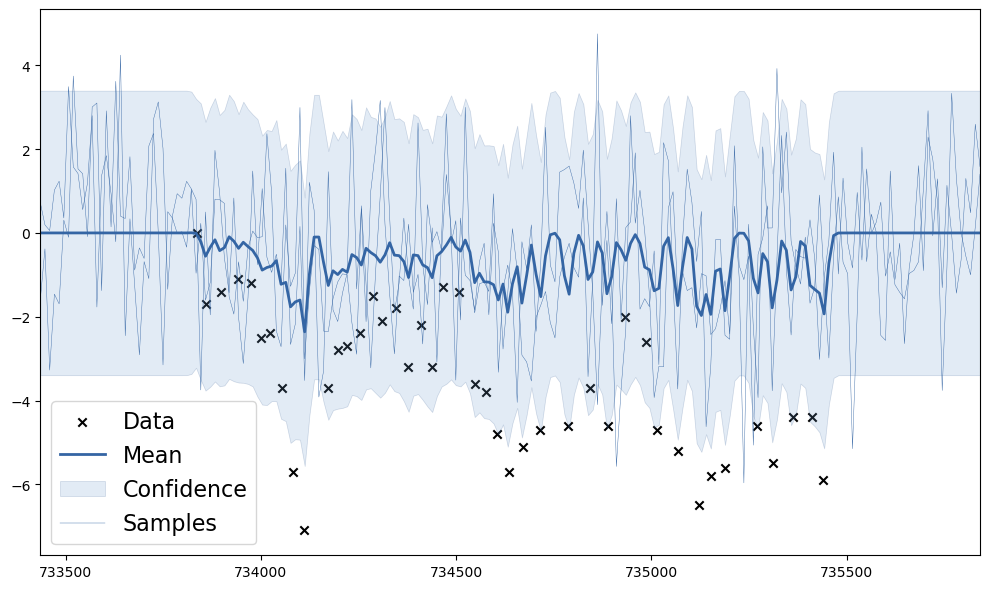

In [104]:
# We can change the hyperparameters (kernel parameters and noise variance) by hand
# from the kernel object or from the model object. For example:

# CHOOSE YOUR OWN VALUES
k.variance = 1
m.rbf.lengthscale = 10
m.Gaussian_noise.variance = 2


fig = m.plot(
    samples = 2,        # number of samples of possible functions (0 for clean plot)
    plot_data = True,   # show data points
    legend = True       # show the plot legend
)

## Hyperparameter learning

Instead of selecting the hyperparameters by hand, we can learn them from the data. By default, GPy uses the log-likelihood of the evidence to estimate the optimal parameters.
$$
\theta^* = \arg\max_\theta \log p(\mathbf{y}|\mathbf{X})
$$

In practice, the optimization algorithm used is for minimization. Thus, we minimize the negative log-likelihood, which should give the same result.

$$
\theta^* = \arg\min_\theta - \log p(\mathbf{y}|\mathbf{X})
$$

You can see how the "Objective" (negative log-likelihood) value decreases compared to the hand selected parameters.

GP_regression.,value,constraints,priors
rbf.variance,12.341664106873136,+ve,
rbf.lengthscale,111.26518826464623,+ve,
Gaussian_noise.variance,0.5169512932676762,+ve,


GP_regression.,value,constraints,priors
sum.RBF.variance,0.143636264692036,+ve,
sum.RBF.lengthscale,2.0,+ve,
sum.Matern52.variance,12.859371769455702,+ve,
sum.Matern52.lengthscale,173.39419102640005,+ve,
Gaussian_noise.variance,0.3392864193863126,+ve,


GP_regression.,value,constraints,priors
Cosine.variance,1.0095715635559979,+ve,
Cosine.lengthscale,0.01641816743868503,+ve,
Gaussian_noise.variance,13.306458018721967,+ve,


Text(0.5, 1.0, 'Cosine kernel')

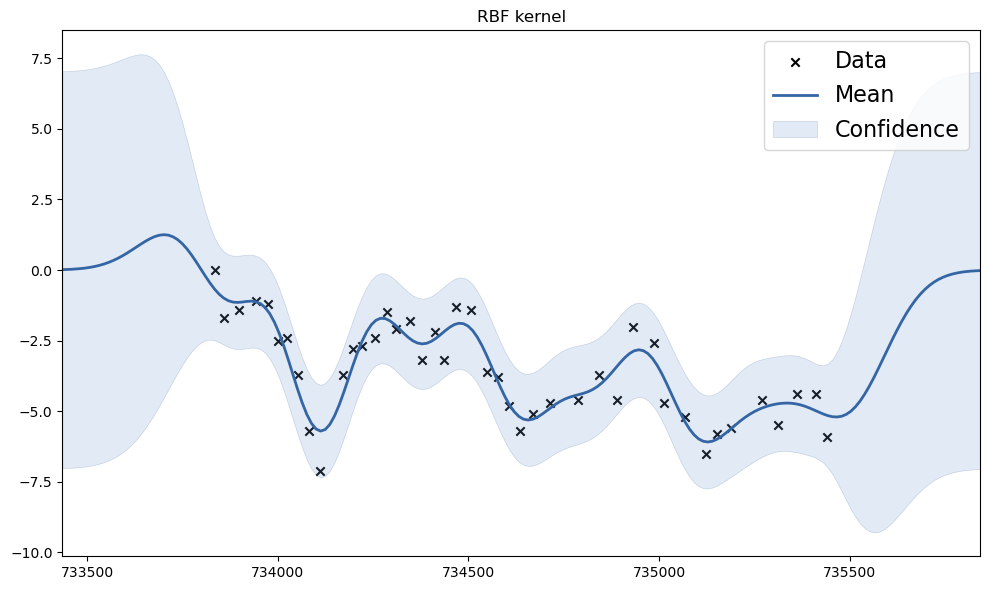

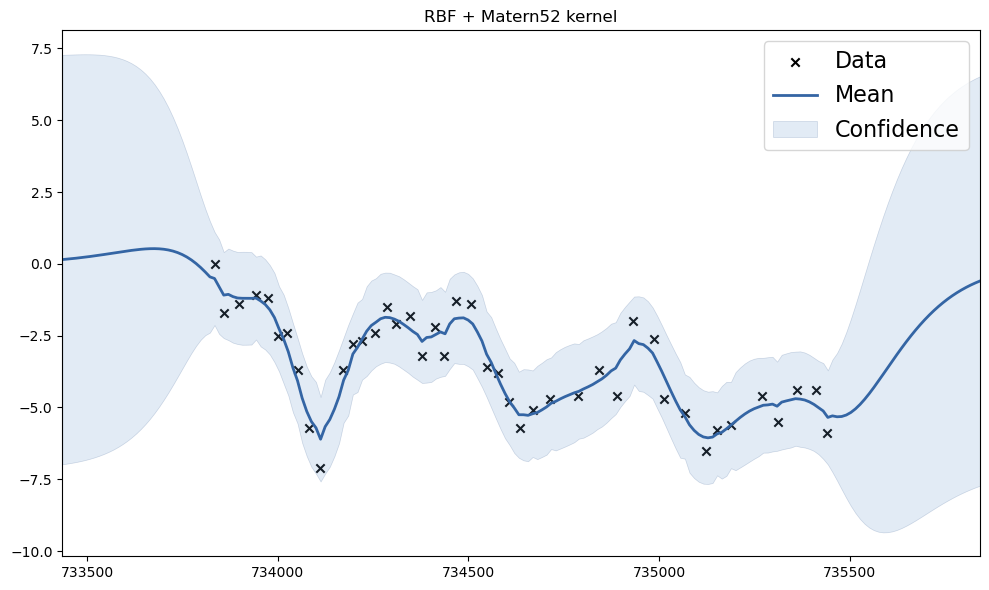

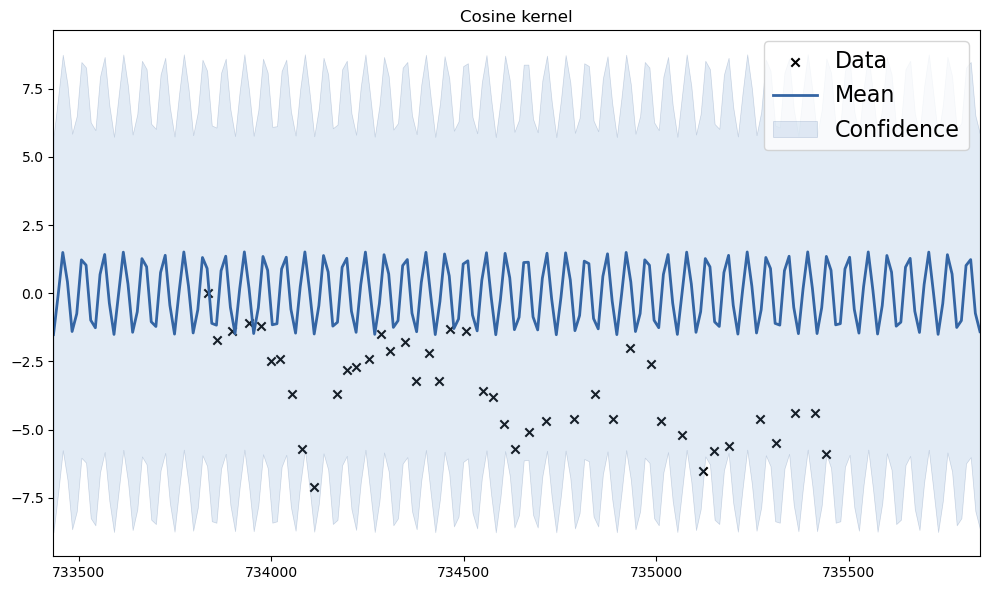

In [106]:
m.optimize()
m_C.optimize()
m_sum.optimize()

# Preview the model's configuration after learning
display(m)
display(m_sum)
display(m_C)


m.plot()
plt.title("RBF kernel")
m_sum.plot()
plt.title("RBF + Matern52 kernel")
m_C.plot()
plt.title("Cosine kernel")

We are using gradient methods to find the optimal hyperparameter. A common problem of gradient methods is that they can get stuck in local optima. To avoid that, we can run multiple optimizations from different initializations. With GPy we can do this with `optimize_restarts()`.

**WARNING**: The optimization is repeated for every restart. If we set `num_restarts` to a large number, we might need to wait a long time.

In [123]:
print("RBF kernel")
m.optimize_restarts(num_restarts = 5)
print("\n RBF + Matern52 kernel")
m_sum.optimize_restarts(num_restarts = 5)
print("\n Cosine kernel")
m_C.optimize_restarts(num_restarts = 5)


RBF kernel
Optimization restart 1/5, f = 75.04179535244819
Optimization restart 2/5, f = 120.01230373544291
Optimization restart 3/5, f = 120.01230373544621
Optimization restart 4/5, f = 120.01230373544288
Optimization restart 5/5, f = 120.01230373579617

 RBF + Matern52 kernel
Optimization restart 1/5, f = 73.12169116257192
Optimization restart 2/5, f = 120.01230373570763
Optimization restart 3/5, f = 120.01230373554992
Optimization restart 4/5, f = 120.01230373549616
Optimization restart 5/5, f = 120.01230373585543

 Cosine kernel
Optimization restart 1/5, f = 116.33755921745124
Optimization restart 2/5, f = 119.6743065501465
Optimization restart 3/5, f = 119.36403386227741
Optimization restart 4/5, f = 119.69042222755931
Optimization restart 5/5, f = 120.00975213688629


# Your tasks
Revisit the previous sections trying diferent kernels, combinations of kernels, tuning the parameters "by hand" or throught ML (maximum likelihood, using `optimize`.

*   Which kernel provide the best fit? We have already found a metric in GPy for the fitness of the model.
*   Would it be possible to get a better fit than by ML? Hint: run the optimization multiple times with different initializations and compare the results.
*   Compare the noiseless (`predict_noiseless` or `plot_noiseless`) and "normal" predictions (`predict` or `plot`). Which one would you use to make decisions? Why?

Bayesian methods are much more interestings in applications with incomplete data. Try to repeat the process with just a selection of the whole dataset. For this, you can use the `subsample` variable in the data loading. We will use only 1 point for every `subsample` points.



## Plots of bests models

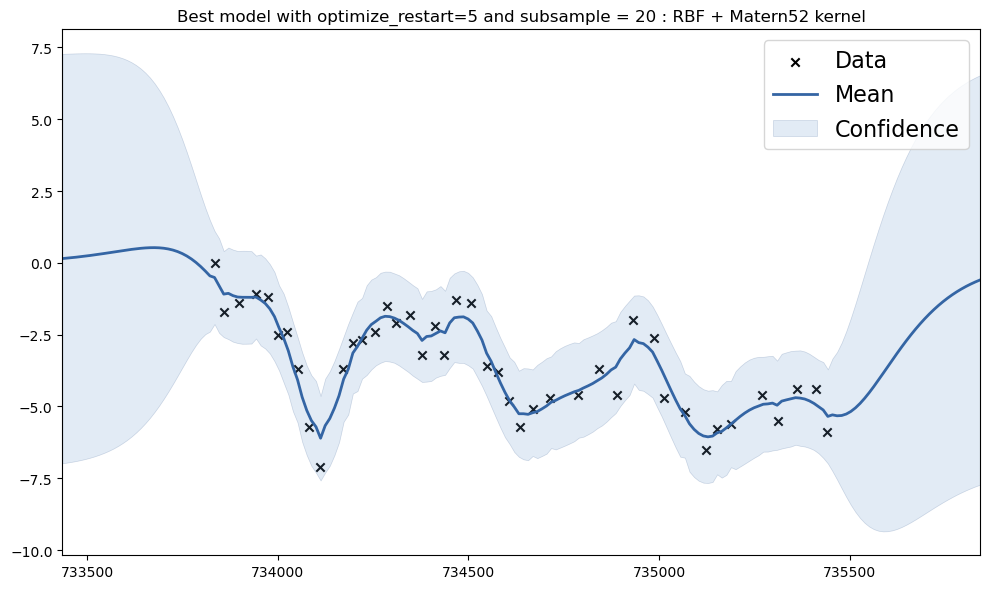

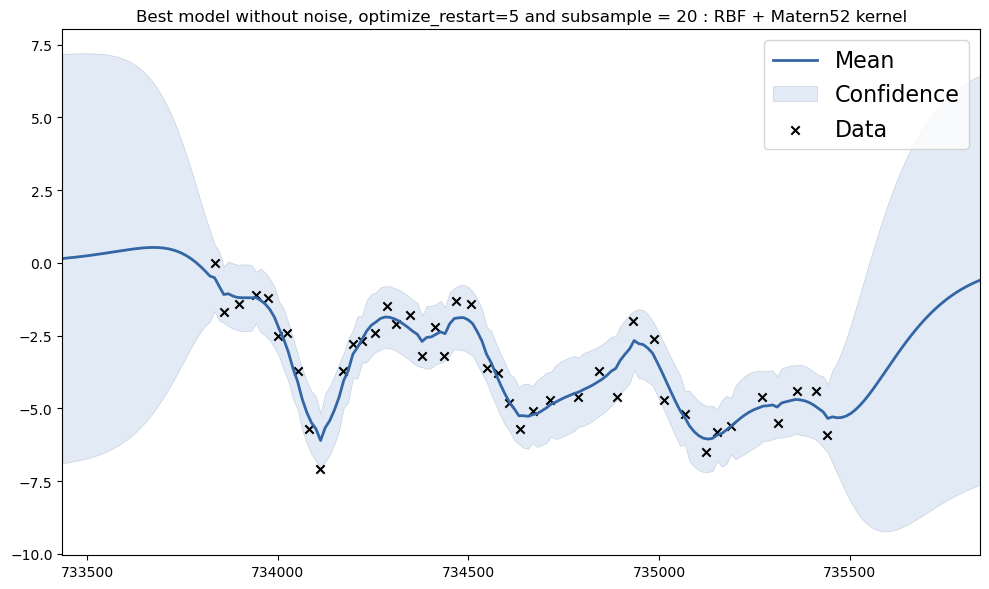

In [140]:
m_sum.plot()
plt.title("Best model with optimize_restart=5 and subsample = 20 : RBF + Matern52 kernel")

m_sum.plot_noiseless()
plt.scatter(X, Y, color='black', marker='x',label='Data')
plt.legend(loc='upper right')
plt.title("Best model without noise, optimize_restart=5 and subsample = 20 : RBF + Matern52 kernel")
plt.show()

Which one would you use to make decisions? Why?

The election depends on the application. We would choose the noisy model if it would be applied in a real-world task, where the noise of the data would enrich the whole model. Otherwise, if the model would be applied in a simulation, for instance, the noiseless model would be a better choice to make predictions. 